# UHI Data Download and Processing Pipeline

Configured for downloading Sentinel-2b, Landsat-LST mosaics, DSM and DEM data from planetary computer within a bounding box defined by a csv of UHI measurements.
Designed to work for NYC but can be extended to other cities. Requires ground-level intraday UHI measurements.

## 1. Setup and Dependencies

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import logging
import requests
import os
from tqdm import tqdm
import subprocess
import zipfile # For more robust unzipping
import time
import pystac_client
import pystac
import planetary_computer
import stackstac
from pathlib import Path
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.dates as mdates
import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display
from datetime import datetime
import numpy.ma as ma
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import rasterio


# Imports for tile index processing
import geopandas as gpd
from shapely.geometry import box

project_root = Path(os.getcwd()).parent  # Assumes notebook is in 'notebooks' subdir
sys.path.insert(0, str(project_root))

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## 2. Global Config

In [ ]:
city_name = "NYC"

# Time window
sentinel_time_window = "2021-06-01/2021-09-01"
lst_time_window = "2021-06-01/2021-09-01"

# Input files and general settings
data_dir = Path("data")
abs_output_dir = project_root / data_dir
uhi_csv = data_dir / city_name / "uhi.csv" # Path to UHI data
abs_uhi_csv = project_root / uhi_csv

if not abs_uhi_csv.exists():
    raise FileNotFoundError(f"UHI data CSV not found at {abs_uhi_csv}. Cannot derive bounds.")
print(f"Loading bounds from UHI data: {abs_uhi_csv}")
uhi_df = pd.read_csv(abs_uhi_csv)
# Check if required columns exist
required_cols = ['Longitude', 'Latitude']
if not all(col in uhi_df.columns for col in required_cols):
     raise ValueError(f"UHI CSV must contain columns: {required_cols}")

# Load bounds
bounds = [
    uhi_df['Longitude'].min(),
    uhi_df['Latitude'].min(),
    uhi_df['Longitude'].max(),
    uhi_df['Latitude'].max()
]

# Load observation day
first_datetime_obj = pd.to_datetime(uhi_df['datetime'].iloc[0], format='%d-%m-%Y %H:%M')
# Format the date object into 'YYYY-MM-DD' string format
uhi_date_str = first_datetime_obj.strftime('%Y-%m-%d')
print(f"Representative UHI date (from first row): {uhi_date_str}")

Loading bounds from UHI data: /home/jupyter/MLC-Project/data/NYC/uhi.csv
Representative UHI date (from first row): 2021-07-24


## 3a. Download Satellite Data for Cities

Now we'll download satellite imagery data (Sentinel-2 median composites, Landsat LST medians) for specific cities and time periods derived from the UHI data timestamps. Data is saved locally for use by the dataloader.

In [ ]:
from ingest.get_median import create_and_save_cloudless_mosaic
from ingest.create_sat_tensor_files import download_single_lst_median
import pandas as pd
from pathlib import Path
import os

# Parameters for Cloudless Mosaic 
mosaic_bands = ["B02", "B03", "B04", "B08", "B11"] # RGB+NIR+SWIR16 for NDBI compatibility
mosaic_resolution_m = 10
mosaic_cloud_cover = 30

# Parameters for LST Median
include_lst = True        
lst_resolution_m = 30      # 30m native resolution for Landsat LST

# Generate output path for the mosaic based on the new time window
start_dt_str = sentinel_time_window.split('/')[0].replace('-','')
end_dt_str = sentinel_time_window.split('/')[1].replace('-','')
band_str = "_".join(mosaic_bands)
cloudless_mosaic_filename = f"sentinel_{city_name}_{start_dt_str}_to_{end_dt_str}_cloudless_mosaic.npy"
cloudless_mosaic_path = abs_output_dir / city_name / "sat_files" / cloudless_mosaic_filename
# --- Verification ---
print(f"City: {city_name}")
print(f"Sentinel-2 Time Window: {sentinel_time_window}")
print(f"Sentinel-2 Cloud Cover Threshold: {mosaic_cloud_cover}%")
print(f"LST Time Window: {lst_time_window}")
print(f"Bounds derived from {uhi_csv.name}: {bounds}")
print(f"Target mosaic output path: {cloudless_mosaic_path}")
print(f"Include LST: {include_lst}")


City: NYC
Sentinel-2 Time Window: 2021-06-01/2021-09-01
Sentinel-2 Cloud Cover Threshold: 30%
LST Time Window: 2021-06-01/2021-09-01
Bounds derived from uhi.csv: [-73.99445667, 40.75879167, -73.87945833, 40.85949667]
Target mosaic output path: /home/jupyter/MLC-Project/data/NYC/sat_files/sentinel_NYC_20210601_to_20210901_cloudless_mosaic.npy
Include LST: True


In [ ]:
print(f"\n--- Generating Cloudless Mosaic ({sentinel_time_window}) ---")

mosaic_output_path = create_and_save_cloudless_mosaic(
    city_name=city_name,
    bounds=bounds,
    output_dir=abs_output_dir,
    time_window=sentinel_time_window, 
    selected_bands=mosaic_bands,
    resolution_m=mosaic_resolution_m,
    cloud_cover=mosaic_cloud_cover
)

if mosaic_output_path:
    print(f"Cloudless mosaic saved/found at: {mosaic_output_path}")
else:
    raise RuntimeError("Failed to generate cloudless mosaic.")

print(f"\n--- Downloading Single LST Median (Include: {include_lst}, Window: {lst_time_window}) ---")

single_lst_median_file_path = None 
if include_lst:
    single_lst_median_file_path = download_single_lst_median(
        city_name=city_name,
        bounds=bounds,
        output_dir=abs_output_dir,
        time_window=lst_time_window,
        resolution_m=lst_resolution_m
    )

    if single_lst_median_file_path:
        print(f"Single LST median saved/found at: {single_lst_median_file_path}")
    else:
        print("Failed to generate single LST median.")
else:
    print("Skipping LST median download as include_lst is False.")

# --- Verification ---
sat_files_check_dir = Path(abs_output_dir) / city_name / "sat_files"
print(f"\nVerifying output files:")
print(f"  Mosaic path ({cloudless_mosaic_path.name}) exists: {cloudless_mosaic_path.exists()}")
if include_lst:
    lst_start_str = lst_time_window.split('/')[0].replace('-','')
    lst_end_str = lst_time_window.split('/')[1].replace('-','')
    expected_lst_filename = f"lst_{city_name}_median_{lst_start_str}_to_{lst_end_str}.npy"
    expected_lst_path = sat_files_check_dir / expected_lst_filename
    print(f"  Single LST median path ({expected_lst_filename}) exists: {expected_lst_path.exists()}")
    if single_lst_median_file_path and not single_lst_median_file_path.exists():
         print(f"Warning: LST download function returned a path but it doesn't exist: {single_lst_median_file_path}")
         single_lst_median_file_path = None 
    elif not single_lst_median_file_path and expected_lst_path.exists():
         single_lst_median_file_path = expected_lst_path


2025-05-11 23:45:59,903 - INFO - Cloudless mosaic /home/jupyter/MLC-Project/data/NYC/sat_files/sentinel_NYC_20210601_to_20210901_cloudless_mosaic.npy already exists. Skipping generation.
2025-05-11 23:45:59,904 - INFO - Using provided LST time window: 2021-06-01/2021-09-01
2025-05-11 23:45:59,905 - INFO - Single LST median file /home/jupyter/MLC-Project/data/NYC/sat_files/lst_NYC_median_20210601_to_20210901.npy already exists. Skipping generation.



--- Generating Cloudless Mosaic (2021-06-01/2021-09-01) ---
Cloudless mosaic saved/found at: /home/jupyter/MLC-Project/data/NYC/sat_files/sentinel_NYC_20210601_to_20210901_cloudless_mosaic.npy

--- Downloading Single LST Median (Include: True, Window: 2021-06-01/2021-09-01) ---
Single LST median saved/found at: /home/jupyter/MLC-Project/data/NYC/sat_files/lst_NYC_median_20210601_to_20210901.npy

Verifying output files:
  Mosaic path (sentinel_NYC_20210601_to_20210901_cloudless_mosaic.npy) exists: True
  Single LST median path (lst_NYC_median_20210601_to_20210901.npy) exists: True


## 3b. Visualise Satellite and UHI Data

### Helper

In [ ]:
def update_plot(timestamp, grid_resolution_m):
    # Filter data for selected timestamp
    if 'datetime_processed' in uhi_df.columns:
        timestamp_data = uhi_df[uhi_df['datetime_processed'] == timestamp]
    else:
        timestamp_data = uhi_df  # Use all data if no timestamp column
    
    if len(timestamp_data) == 0:
        print(f"No data for timestamp {timestamp}")
        plt.figure(figsize=(12, 10))
        plt.text(0.5, 0.5, f"No UHI data for this timestamp", 
                 horizontalalignment='center', verticalalignment='center', 
                 transform=plt.gca().transAxes, fontsize=14)
        plt.title(f"UHI Data - {timestamp}")
        try:
            plt.tight_layout()
        except ValueError as e:
            print(f"Warning: tight_layout failed during no-data plot: {e}")
        plt.show()
        return
    
    grid_sum_uhi = np.zeros((len(lat_grid)-1, len(lon_grid)-1), dtype=float)
    grid_counts = np.zeros((len(lat_grid)-1, len(lon_grid)-1), dtype=int)
    
    uhi_column = None
    for col in ['UHI Index', 'uhi', 'UHI', 'delta_T']: 
        if col in timestamp_data.columns:
            uhi_column = col
            break
    
    if uhi_column is None:
        print("No UHI value column found (looked for 'UHI Index', 'uhi', 'UHI', 'delta_T')")
        return
    
    for _, row in timestamp_data.iterrows():
        try:
            lon_idx = np.searchsorted(lon_grid, row['Longitude']) - 1
            lat_idx = np.searchsorted(lat_grid, row['Latitude']) - 1
            
            if 0 <= lon_idx < grid_sum_uhi.shape[1] and 0 <= lat_idx < grid_sum_uhi.shape[0]:
                uhi_value = row[uhi_column]
                if np.isfinite(uhi_value):
                    grid_sum_uhi[lat_idx, lon_idx] += uhi_value
                    grid_counts[lat_idx, lon_idx] += 1
        except Exception as e:
            print(f"Error binning point at Lon: {row.get('Longitude', 'N/A')}, Lat: {row.get('Latitude', 'N/A')}: {e}")
            
    grid_avg = np.full_like(grid_sum_uhi, np.nan)
    mask_counts_positive = grid_counts > 0
    grid_avg[mask_counts_positive] = grid_sum_uhi[mask_counts_positive] / grid_counts[mask_counts_positive]
    
    grid_masked = ma.masked_invalid(grid_avg) 
    
    vmin = 0.0
    vmax = 1.1

    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    extent = [bounds[0], bounds[2], bounds[1], bounds[3]]

    rgb_masked_display = ma.masked_invalid(rgb_norm) 
    ax.imshow(rgb_masked_display, origin='upper', extent=extent, transform=ccrs.PlateCarree(), zorder=1)

    valid_data_exists_in_grid = np.any(~ma.getmask(grid_masked))

    my_cmap = plt.cm.get_cmap('YlOrRd').copy()
    my_cmap.set_bad(color=(0.0, 0.0, 0.0, 0.0)) 

    if valid_data_exists_in_grid:
        mesh = ax.pcolormesh(
            lon_grid, lat_grid, 
            grid_masked,
            cmap=my_cmap, 
            alpha=0.7,
            transform=ccrs.PlateCarree(),
            shading='auto',
            vmin=vmin,
            vmax=vmax,
            zorder=2
        )

        cbar = plt.colorbar(mesh, ax=ax, shrink=0.7, pad=0.05)
        cbar.set_label(f'UHI Index ({uhi_column}, 0-1)')
    else:
        ax.text(0.5, 0.95, "No valid UHI data to display for this timestamp's grid",
                horizontalalignment='center', transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.7), zorder=3)

    ax.coastlines(resolution='10m', color='white', linewidth=0.5, zorder=4)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--', zorder=5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    if isinstance(timestamp, (pd.Timestamp, datetime)):
        title_timestamp = timestamp.strftime('%Y-%m-%d %H:%M')
    else:
        title_timestamp = str(timestamp)

    plt.title(f'UHI Index ({grid_resolution_m}m) Over Sentinel-2 RGB\n{title_timestamp} - {city_name}', zorder=6)

    ax.text(
        0.02, 0.02, 
        f"Grid res: {grid_resolution_m}m | UHI Pts: {len(timestamp_data)} | Max UHI in grid: {np.nanmax(grid_avg):.2f}",
        transform=ax.transAxes,
        bbox={"facecolor":"white", "alpha":0.7, "pad":5},
        fontsize=10, zorder=7
    )

    try:
        plt.tight_layout()
    except ValueError as e:
        print(f"Warning: tight_layout failed: {e}")

    plt.show()

### Visualise UHI over Sentinel Mosaic

In [ ]:
# --- Set Grid Resolution for visualising UHI Data ---
grid_resolution_m = 50  # Grid cell size in meters (adjust as needed)

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import numpy.ma as ma
import ipywidgets as widgets
from ipywidgets import interact, fixed
from IPython.display import display
from datetime import datetime

# --- Load Data ---
# Sentinel-2 Cloudless Mosaic
sat_files_dir = abs_output_dir / city_name / "sat_files"
mosaic_path = sat_files_dir / f"sentinel_{city_name}_{sentinel_time_window.split('/')[0].replace('-', '')}_to_{sentinel_time_window.split('/')[1].replace('-', '')}_cloudless_mosaic.npy"
mosaic = np.load(mosaic_path)
print(f"Mosaic shape: {mosaic.shape}")  # Should be (4, H, W) for bands

# UHI Data
uhi_df = pd.read_csv(abs_uhi_csv)
print(f"UHI data shape: {uhi_df.shape}")

# --- Process RGB Data ---
if mosaic.shape[0] >= 3:
    rgb = mosaic[:3] 
    rgb = np.transpose(rgb, (1, 2, 0))
    rgb_masked = ma.masked_invalid(rgb)
    rgb_norm = np.zeros_like(rgb, dtype=np.float32)
    for i in range(3):
        valid_data = rgb[:, :, i][~np.isnan(rgb[:, :, i])]
        if len(valid_data) > 0:
            # Clip to 2nd and 98th percentile to prevent extreme outliers.
            p2, p98 = np.percentile(valid_data, (2, 98))
            channel_norm = np.clip((rgb[:, :, i] - p2) / (p98 - p2), 0, 1)
            rgb_norm[:, :, i] = np.where(np.isnan(rgb[:, :, i]), np.nan, channel_norm)
        else:
            print(f"Warning: Channel {i} contains only NaN values")
    
    # --- Process UHI Data with Timestamps ---
    timestamp_col = 'datetime' if 'datetime' in uhi_df.columns else 'timestamp'
    
    if timestamp_col in uhi_df.columns:
        # Convert timestamps to datetime
        try:
            if isinstance(uhi_df[timestamp_col].iloc[0], str):
                try:
                    # Try common formats
                    uhi_df['datetime_processed'] = pd.to_datetime(uhi_df[timestamp_col], format='%d-%m-%Y %H:%M')
                except ValueError:
                    try:
                        uhi_df['datetime_processed'] = pd.to_datetime(uhi_df[timestamp_col])
                    except:
                        print(f"Could not parse timestamps from {timestamp_col} column")
            else:
                uhi_df['datetime_processed'] = pd.to_datetime(uhi_df[timestamp_col])
            
            # Get unique timestamps for the slider
            unique_timestamps = sorted(uhi_df['datetime_processed'].unique())
            timestamp_options = [(ts.strftime('%Y-%m-%d %H:%M'), ts) for ts in unique_timestamps]
            
            print(f"Found {len(unique_timestamps)} unique timestamps")
        except Exception as e:
            print(f"Error processing timestamps: {e}")
            unique_timestamps = [datetime.now()]
            timestamp_options = [("No timestamp data", datetime.now())]
    else:
        print(f"No timestamp column found. Expected '{timestamp_col}'")
        unique_timestamps = [datetime.now()]
        timestamp_options = [("No timestamp data", datetime.now())]
    
    # Convert meters to degrees approximately
    lon_center = (bounds[0] + bounds[2]) / 2
    lat_degree_per_meter = 1 / 111000  # Approximate degrees latitude per meter
    lon_degree_per_meter = 1 / (111000 * np.cos(np.radians(lon_center)))  # Approximate degrees longitude per meter
    
    # Convert resolution to degree units
    lat_resolution = grid_resolution_m * lat_degree_per_meter
    lon_resolution = grid_resolution_m * lon_degree_per_meter
    
    # --- Create Grid for UHI Data ---
    # Define grid boundaries
    lon_min, lat_min, lon_max, lat_max = bounds
    lon_grid = np.arange(lon_min, lon_max + lon_resolution, lon_resolution)
    lat_grid = np.arange(lat_min, lat_max + lat_resolution, lat_resolution)
    
    print(f"Grid size: {len(lon_grid)} x {len(lat_grid)} cells")
    print(f"Grid cell size: ~{grid_resolution_m}m ({lon_resolution:.6f}° x {lat_resolution:.6f}°)")        

timestamp_dropdown = widgets.Dropdown(
    options=timestamp_options,
    description='Timestamp:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)
interact(update_plot, timestamp=timestamp_dropdown, grid_resolution_m=fixed(grid_resolution_m))

Mosaic shape: (5, 1119, 1278)
UHI data shape: (11229, 4)
Found 59 unique timestamps
Grid size: 72 x 225 cells
Grid cell size: ~50m (0.001628° x 0.000450°)


interactive(children=(Dropdown(description='Timestamp:', layout=Layout(width='50%'), options=(('2021-07-24 15:…

<function __main__.update_plot(timestamp, grid_resolution_m)>

## 4a. Download DEM/DSM Data

In [11]:
# ─────────────────────────────────────────────────────────────────────────────
# CONFIG
# ─────────────────────────────────────────────────────────────────────────────
# DEM/DSM specific settings

# --- URLs and Paths ---
CRS_WGS84 = "EPSG:4326"

# Ensure the 'sat_files' directory exists
sat_files_dir = abs_output_dir / city_name / "sat_files"
sat_files_dir.mkdir(parents=True, exist_ok=True)

# --- Target Resolution --- # 
TARGET_ELEV_RESOLUTION_M = 10 # Target resolution in meters for final output

# --- Define nodata value --- #
ELEV_NODATA_VALUE = np.nan # Use a float value for both

# --- Define final expected TIF paths --- #
final_dem_path_tif = sat_files_dir / f"{city_name.lower()}_dem_{TARGET_ELEV_RESOLUTION_M}m_pc.tif" 
final_dsm_path_tif = sat_files_dir / f"{city_name.lower()}_dsm_{TARGET_ELEV_RESOLUTION_M}m_pc.tif"

In [12]:
import rioxarray

# Define DEM collection ID
dem_collection_id = "nasadem"
dem_resolution_tag = "native-resolution" # Approx 30m for NASADEM

# Construct filename
nyc_dem_filename = f"{city_name.lower()}_dem_{dem_collection_id}_{dem_resolution_tag}_pc.tif"
final_dem_path_tif = sat_files_dir / nyc_dem_filename
dem_path_relative = None # Initialize

if final_dem_path_tif.exists():
    print(f"DEM file {final_dem_path_tif.name} already exists. Skipping download.")
    dem_path_relative = Path("data") / city_name / "sat_files" / final_dem_path_tif.name
else:
    print(f"--- Downloading DEM for {city_name} from Planetary Computer ({dem_collection_id}) ---")
    
    try:
        catalog = pystac_client.Client.open(
            "https://planetarycomputer.microsoft.com/api/stac/v1",
            modifier=planetary_computer.sign_inplace
        )
        
        search_dem = catalog.search(
            collections=[dem_collection_id],
            bbox=bounds # STAC search still uses the bounds to find relevant items
        )
        
        items_dem = search_dem.item_collection()
        print(f"Found {len(items_dem)} items for the bounding box.")
        
        if not items_dem:
            raise ValueError(f"No items found for the specified bounding box from collection {dem_collection_id}.")

        print("Stacking DEM data...")
        dem_data_stacked_raw = stackstac.stack(
            items_dem,
            assets=["elevation"], # Asset name for NASADEM
            epsg=4326,      
            # resolution=None, # Let stackstac use native resolution of the item(s)
            dtype=np.float64, # NASADEM is often int16, float32 is good for processing
            fill_value=ELEV_NODATA_VALUE, # np.nan
            rescale=False # NASADEM usually doesn't require rescaling
            # No explicit bounds or bounds_latlon here, stack the full extent of found item(s)
        )
        
        print(f"Raw stacked DEM data shape: {dem_data_stacked_raw.shape}")

        # Clip the stacked data to the desired bounds
        # Ensure 'bounds' is [lon_min, lat_min, lon_max, lat_max]
        print(f"Clipping stacked DEM to bounds: {bounds}")
        dem_data_stacked = dem_data_stacked_raw.rio.clip_box(
            minx=bounds[0],
            miny=bounds[1],
            maxx=bounds[2],
            maxy=bounds[3],
            crs="EPSG:4326" # Assuming your 'bounds' are in EPSG:4326
        )
        print(f"Clipped DEM data shape: {dem_data_stacked.shape}")
        
        # Continue with median/band selection as before
        if "time" in dem_data_stacked.dims:
            dem_data = dem_data_stacked.median("time", skipna=True)
        else:
            dem_data = dem_data_stacked
        
        if "band" in dem_data.dims: # NASADEM 'elevation' asset should be single band
             if dem_data.sizes["band"] == 1:
                 dem_data = dem_data.isel(band=0)
             elif dem_data.sizes["band"] > 1: # Should not happen for NASADEM elevation
                print(f"Warning: DEM stack has multiple bands ({dem_data.sizes['band']}), selecting first band.")
                dem_data = dem_data.isel(band=0)
            
        dem_data = dem_data.squeeze() 

        print(f"Processed DEM data shape (after clip, median, squeeze): {dem_data.shape}")

        if dem_data.rio.crs is None: # Should be set by stackstac
            print(f"DEM data has no CRS after processing, writing {CRS_WGS84}")
            dem_data = dem_data.rio.write_crs(CRS_WGS84)
        # No need to reproject if already in EPSG:4326 and native resolution is kept
        
        dem_final = dem_data 
        dem_final.rio.write_nodata(ELEV_NODATA_VALUE, inplace=True)

        print(f"DEM data shape (final): {dem_final.shape}")
        
        print(f"Saving DEM ({dem_resolution_tag}) to: {final_dem_path_tif}")
        dem_final.rio.to_raster(
            final_dem_path_tif,
            driver="COG", 
            compress="DEFLATE",
        )
        print(f"Successfully downloaded and saved DEM to {final_dem_path_tif}")
        dem_path_relative = Path("data") / city_name / "sat_files" / final_dem_path_tif.name

    except Exception as e:
        print(f"An error occurred during DEM download or processing: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for more details

# --- Final Check for DEM ---
# (rest of the cell remains the same)
print("\n--- Final Status (DEM) ---")
if final_dem_path_tif.exists() and dem_path_relative is not None:
    print(f"DEM file exists: {final_dem_path_tif}")
    with rioxarray.open_rasterio(final_dem_path_tif) as src: 
        print(f"  CRS: {src.rio.crs}")
        print(f"  Bounds: {src.rio.bounds()}")
        print(f"  Shape: {src.shape}")
        print(f"  Resolution: {src.rio.resolution()}")
else:
    print(f"DEM file NOT found or path not set: {final_dem_path_tif}.")
    dem_path_relative = None 

print(f"DEM relative path: {dem_path_relative}")

DEM file nyc_dem_nasadem_native-resolution_pc.tif already exists. Skipping download.

--- Final Status (DEM) ---
DEM file exists: /home/jupyter/MLC-Project/data/NYC/sat_files/nyc_dem_nasadem_native-resolution_pc.tif


NameError: name 'rioxarray' is not defined

In [8]:
# --- Download Copernicus DSM --- #
import pystac_client
import planetary_computer
import stackstac
import rioxarray
import numpy as np
from pathlib import Path # Ensure Path is imported
# from rasterio.warp import Resampling # Not used when no resampling

# Define DSM collection ID
dsm_collection_id = "cop-dem-glo-30"
dsm_resolution_tag = "native-resolution" # For filename

# Construct filename
nyc_dsm_filename = f"{city_name.lower()}_dsm_{dsm_collection_id}_{dsm_resolution_tag}_pc.tif"
final_dsm_path_tif = sat_files_dir / nyc_dsm_filename
dsm_path_relative = None # Initialize

if final_dsm_path_tif.exists():
    print(f"DSM file {final_dsm_path_tif.name} already exists. Skipping download.")
    dsm_path_relative = Path("data") / city_name / "sat_files" / final_dsm_path_tif.name
else:
    print(f"--- Downloading DSM for {city_name} from Planetary Computer ({dsm_collection_id}) ---")
    
    try:
        catalog = pystac_client.Client.open(
            "https://planetarycomputer.microsoft.com/api/stac/v1",
            modifier=planetary_computer.sign_inplace
        )
        
        search_dsm = catalog.search(
            collections=[dsm_collection_id],
            bbox=bounds
        )
        
        items_dsm = search_dsm.item_collection()
        print(f"Found {len(items_dsm)} items for the bounding box.")
        
        if not items_dsm:
            raise ValueError(f"No items found for the specified bounding box from collection {dsm_collection_id}.")

        print("Stacking DSM data...")
        dsm_data_stacked = stackstac.stack(
            items_dsm,
            assets=["data"], 
            epsg=4326,      
            dtype=np.float64,
            fill_value=ELEV_NODATA_VALUE, 
            rescale=False,
            bounds_latlon=bounds
        )
        
        if "time" in dsm_data_stacked.dims:
            dsm_data = dsm_data_stacked.max("time", skipna=True) # Max for DSM
        else:
            dsm_data = dsm_data_stacked
        
        if "band" in dsm_data.dims: 
             if dsm_data.sizes["band"] == 1:
                 dsm_data = dsm_data.isel(band=0)
             elif dsm_data.sizes["band"] > 1:
                print(f"Warning: DSM stack has multiple bands ({dsm_data.sizes['band']}), selecting first band.")
                dsm_data = dsm_data.isel(band=0)

        dsm_data = dsm_data.squeeze() 

        print(f"Initial stacked DSM data shape: {dsm_data.shape}")

        if dsm_data.rio.crs is None:
            print(f"DSM data has no CRS, writing {CRS_WGS84}")
            dsm_data = dsm_data.rio.write_crs(CRS_WGS84)
        elif str(dsm_data.rio.crs).upper() != CRS_WGS84.upper():
            print(f"DSM data CRS is {dsm_data.rio.crs}, reprojecting to {CRS_WGS84}")
            dsm_data = dsm_data.rio.reproject(CRS_WGS84)
        
        dsm_final = dsm_data 
        dsm_final.rio.write_nodata(ELEV_NODATA_VALUE, inplace=True)

        print(f"DSM data shape (no resampling): {dsm_final.shape}")
        
        print(f"Saving DSM ({dsm_resolution_tag}) to: {final_dsm_path_tif}")
        dsm_final.rio.to_raster(
            final_dsm_path_tif,
            driver="COG", 
            compress="DEFLATE",
        )
        print(f"Successfully downloaded and saved DSM to {final_dsm_path_tif}")
        dsm_path_relative = Path("data") / city_name / "sat_files" / final_dsm_path_tif.name

    except Exception as e:
        print(f"An error occurred during DSM download or processing: {e}")

# --- Final Check for Copernicus DSM ---
print("\n--- Final Status (DSM) ---")
if final_dsm_path_tif.exists() and dsm_path_relative is not None :
    print(f"DSM file exists: {final_dsm_path_tif}")
    with rioxarray.open_rasterio(final_dsm_path_tif) as src: 
        print(f"  CRS: {src.rio.crs}")
        print(f"  Bounds: {src.rio.bounds()}")
        print(f"  Shape: {src.shape}")
        print(f"  Resolution: {src.rio.resolution()}")
else:
    print(f"DSM file NOT found or path not set: {final_dsm_path_tif}.")
    dsm_path_relative = None

print(f"DSM relative path: {dsm_path_relative}")

# Update config dictionary or print relative paths to be used in config files elsewhere
# Ensure project_root is defined in your notebook
if 'project_root' in locals() or 'project_root' in globals():
    print(f"\nRelative paths for config (relative to project root '{project_root}'):")
    if 'dem_path_relative' in locals() and dem_path_relative:
        print(f"  DEM ({dem_collection_id}): {dem_path_relative}")
    else:
        print(f"  DEM ({dem_collection_id}): Not generated/found.")
    if 'dsm_path_relative' in locals() and dsm_path_relative:
        print(f"  DSM ({dsm_collection_id}): {dsm_path_relative}")
    else:
        print(f"  DSM ({dsm_collection_id}): Not generated/found.")
else:
    print("\nWarning: 'project_root' variable not defined. Cannot print full relative paths for config.")


DSM file nyc_dsm_cop-dem-glo-30_native-resolution_pc.tif already exists. Skipping download.

--- Final Status (DSM) ---
DSM file exists: /home/jupyter/MLC-Project/data/NYC/sat_files/nyc_dsm_cop-dem-glo-30_native-resolution_pc.tif
  CRS: EPSG:4326
  Bounds: (-73.9948611111111, 40.75874999999999, -73.87958333333334, 40.859861111111115)
  Shape: (1, 364, 415)
  Resolution: (0.0002777777777777654, -0.0002777777777777992)
DSM relative path: data/NYC/sat_files/nyc_dsm_cop-dem-glo-30_native-resolution_pc.tif

Relative paths for config (relative to project root '/home/jupyter/MLC-Project'):
  DEM (nasadem): data/NYC/sat_files/nyc_dem_nasadem_native-resolution_pc.tif
  DSM (cop-dem-glo-30): data/NYC/sat_files/nyc_dsm_cop-dem-glo-30_native-resolution_pc.tif


## 4b. Validate DEM/DSM Data

--- Visualizing and Checking Coverage for DSM (nyc_dsm_cop-dem-glo-30_native-resolution_pc.tif) ---
File path: /home/jupyter/MLC-Project/data/NYC/sat_files/nyc_dsm_cop-dem-glo-30_native-resolution_pc.tif

--- Raster Metadata (Full File) ---
CRS: EPSG:4326
Bounds: (-73.9948611111111, 40.75874999999999, -73.87958333333334, 40.859861111111115)
Shape: (1, 364, 415) (bands, height, width)
Resolution: (0.0002777777777777654, -0.0002777777777777992) (x, y)
NoData value: nan


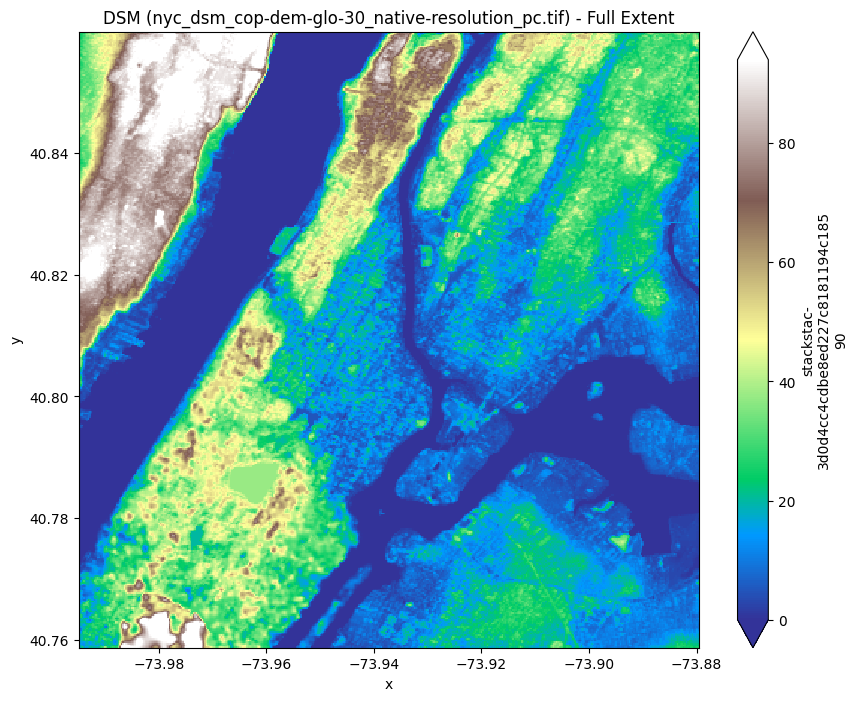


--- Coverage within BBOX ---
Using BBOX: [-73.99445667, 40.75879167, -73.87945833, 40.85949667] (EPSG:4326 assumed)
Coverage within BBOX: 100.00%
  Total pixels in BBOX extent (at raster resolution): 150282
  Valid data pixels in BBOX extent: 150282


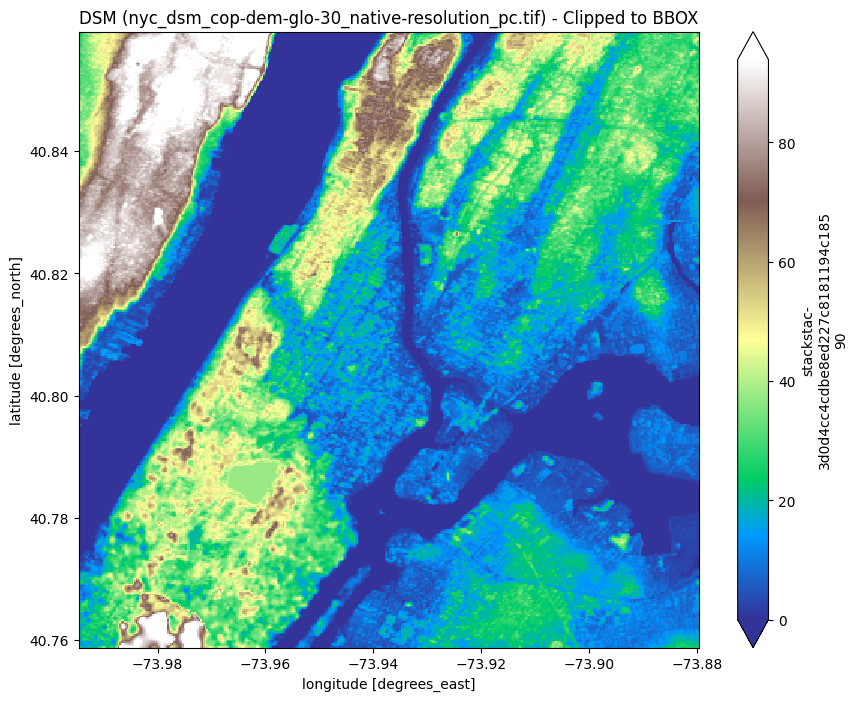

In [9]:
# --- Visualize DEM/DSM and Check Coverage ---

# Flag to choose 'dem' or 'dsm'
VISUALIZE_TYPE = "dsm"

# Ensure necessary imports are available from previous cells or add them here:
# import rioxarray
# import matplotlib.pyplot as plt
# import numpy as np
# from shapely.geometry import box as shapely_box
# from pathlib import Path
# import rasterio # For error handling

# --- Determine file path based on VISUALIZE_TYPE ---
file_to_visualize_path = None
data_label = ""
title_prefix = ""

if VISUALIZE_TYPE.lower() == "dem":
    title_prefix = "DEM"
    if 'final_dem_path_tif' in locals() and final_dem_path_tif.exists():
        file_to_visualize_path = final_dem_path_tif
    elif 'final_dem_path_tif' in globals() and final_dem_path_tif.exists():
        file_to_visualize_path = final_dem_path_tif
    else:
        print(f"DEM file path variable 'final_dem_path_tif' not found or file does not exist. "
              f"Please run the DEM download cell.")
elif VISUALIZE_TYPE.lower() == "dsm":
    title_prefix = "DSM"
    if 'final_dsm_path_tif' in locals() and final_dsm_path_tif.exists():
        file_to_visualize_path = final_dsm_path_tif
    elif 'final_dsm_path_tif' in globals() and final_dsm_path_tif.exists():
        file_to_visualize_path = final_dsm_path_tif
    else:
        print(f"DSM file path variable 'final_dsm_path_tif' not found or file does not exist. "
              f"Please run the DSM download cell.")
else:
    print(f"Invalid VISUALIZE_TYPE: {VISUALIZE_TYPE}. Choose 'dem' or 'dsm'.")

if file_to_visualize_path:
    data_label = f"{title_prefix} ({file_to_visualize_path.name})"
    print(f"--- Visualizing and Checking Coverage for {data_label} ---")
    print(f"File path: {file_to_visualize_path}")

    try:
        # Open the raster data
        rds = rioxarray.open_rasterio(file_to_visualize_path, masked=True)
        
        # Print basic metadata of the loaded file
        print("\n--- Raster Metadata (Full File) ---")
        print(f"CRS: {rds.rio.crs}")
        print(f"Bounds: {rds.rio.bounds()}")
        print(f"Shape: {rds.shape} (bands, height, width)")
        print(f"Resolution: {rds.rio.resolution()} (x, y)")
        print(f"NoData value: {rds.rio.nodata}")

        # Visualization of the full raster
        fig_full, ax_full = plt.subplots(1, 1, figsize=(10, 8))
        # Squeeze the band dimension for plotting
        rds.squeeze().plot.imshow(ax=ax_full, cmap='terrain', robust=True, add_colorbar=True)
        ax_full.set_title(f"{data_label} - Full Extent")
        plt.show()

        # Coverage percentage for the BBOX
        # Ensure 'bounds' variable [lon_min, lat_min, lon_max, lat_max] is available from previous cells
        if 'bounds' in locals() or 'bounds' in globals():
            print(f"\n--- Coverage within BBOX ---")
            print(f"Using BBOX: {bounds} (EPSG:4326 assumed)")
            
            try:
                # Clip the raster to the bounding box
                clipped_rds = rds.rio.clip_box(
                    minx=bounds[0],
                    miny=bounds[1],
                    maxx=bounds[2],
                    maxy=bounds[3],
                    crs="EPSG:4326"  # Assuming bounds are in WGS84
                )
                
                nodata_val = clipped_rds.rio.nodata
                
                # Squeeze the data to remove single band dimension for calculation if present
                clipped_data_array = clipped_rds.squeeze().data

                if np.isnan(nodata_val): # Check if nodata is NaN
                    valid_pixels = np.count_nonzero(~np.isnan(clipped_data_array))
                else:
                    valid_pixels = np.count_nonzero(clipped_data_array != nodata_val)
                
                total_pixels_in_clip = clipped_data_array.size # Total pixels in the 2D data array
                
                if total_pixels_in_clip > 0:
                    coverage_percentage = (valid_pixels / total_pixels_in_clip) * 100
                    print(f"Coverage within BBOX: {coverage_percentage:.2f}%")
                    print(f"  Total pixels in BBOX extent (at raster resolution): {total_pixels_in_clip}")
                    print(f"  Valid data pixels in BBOX extent: {valid_pixels}")
                else:
                    print("The BBOX does not overlap with the raster or results in an empty clip.")

                # Visualize the clipped area
                fig_clip, ax_clip = plt.subplots(1, 1, figsize=(10, 8))
                # Squeeze the band dimension for plotting
                clipped_rds.squeeze().plot.imshow(ax=ax_clip, cmap='terrain', robust=True, add_colorbar=True)
                ax_clip.set_title(f"{data_label} - Clipped to BBOX")
                plt.show()

            except Exception as clip_error: # Catches NoDataInBoundsError, etc.
                print(f"Could not clip raster to BBOX or calculate coverage: {clip_error}")
                print("This might occur if the BBOX is outside the raster extent, "
                      "contains only NoData values, or due to other clipping issues.")
        else:
            print("\n'bounds' variable not found. Skipping BBOX coverage calculation.")

    except rasterio.errors.RasterioIOError:
        print(f"Error: Could not open raster file: {file_to_visualize_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()

elif VISUALIZE_TYPE.lower() in ["dem", "dsm"]:
     # This case means file_to_visualize_path was not set because the variable was missing
     pass # The earlier print statement already handled this.
# else: VISUALIZE_TYPE was invalid, already handled.